In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sms
import matplotlib.pyplot as plt
from scipy import stats
import tqdm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.model_selection import TimeSeriesSplit
from pylab import rcParams
from sklearn.metrics import mean_absolute_error as mae
from tqdm import tqdm_notebook
import warnings
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 100)
df = pd.read_csv('avocado.csv', parse_dates=['Date'], index_col='Date')

In [3]:
df

Unnamed: 0  AveragePrice  Total Volume     4046       4225  \
Date                                                                     
2015-12-27           0          1.33      64236.62  1036.74   54454.85   
2015-12-20           1          1.35      54876.98   674.28   44638.81   
2015-12-13           2          0.93     118220.22   794.70  109149.67   
2015-12-06           3          1.08      78992.15  1132.00   71976.41   
2015-11-29           4          1.28      51039.60   941.48   43838.39   
...                ...           ...           ...      ...        ...   
2018-02-04           7          1.63      17074.83  2046.96    1529.20   
2018-01-28           8          1.71      13888.04  1191.70    3431.50   
2018-01-21           9          1.87      13766.76  1191.92    2452.79   
2018-01-14          10          1.93      16205.22  1527.63    2981.04   
2018-01-07          11          1.62      17489.58  2894.77    2356.13   

              4770  Total Bags  Small Bags  Large Bags  XLarge Bags  \
Date                                                                  
2015-12-27   48.16     8696.87     8603.62       93.25          0.0   
2015-12-20   58.33     9505.56     9408.07       97.49          0.0   
2015-12-13  130.50     8145.35     8042.21      103.14          0.0   
2015-12-06   72.58     5811.16     5677.40      133.76          0.0   
2015-11-29   75.78     6183.95     5986.26      197.69          0.0   
...            ...         ...         ...         ...          ...   
2018-02-04    0.00    13498.67    13066.82      431.85          0.0   
2018-01-28    0.00     9264.84     8940.04      324.80          0.0   
2018-01-21  727.94     9394.11     9351.80       42.31          0.0   
2018-01-14  727.01    10969.54    10919.54       50.00          0.0   
2018-01-07  224.53    12014.15    11988.14       26.01          0.0   

                    type  year            region  
Date                                              
2015-12-27  conventional  2015            Albany  
2015-12-20  conventional  2015            Albany  
2015-12-13  conventional  2015            Albany  
2015-12-06  conventional  2015            Albany  
2015-11-29  conventional  2015            Albany  
...                  ...   ...               ...  
2018-02-04       organic  2018  WestTexNewMexico  
2018-01-28       organic  2018  WestTexNewMexico  
2018-01-21       organic  2018  WestTexNewMexico  
2018-01-14       organic  2018  WestTexNewMexico  
2018-01-07       organic  2018  WestTexNewMexico  

[18249 rows x 13 columns]

# Первичный анализ данных

Датасет продаж авокадо (сорта Хасс) в США в 2015 - 2018 г. 
Значения колонок датасета:
1. Date - дата продажи
2. AveragePrice - средняя цена продажи одного авокадо
3. Total Volume - общее число проданных авокадо
4. 4046 - Число проданных авокадо с продуктовым кодом: 4046, Small Hass Size 60 & smaller (маленький размер, 60 и меньше)
5. 4225 - Число проданных авокадо с продуктовым кодом: 4225, Large Hass Size 40 & 48 (большой размер, 40 и 48)
6. 4770 - Число проданных авокадо с продуктовым кодом: 4770, Extra Large Hass Size 36 & larger (экстра - большой размер, 36 и больше)
7. Total Bags - Общее число проданных пакетов с авокадо (авокадо из пакетов включены в колонку 3)
8. Small Bags - Число проданных маленьких пакетов с авокадо
9. Large Bags - Число проданных больших пакетов с авокадо
10. XLarge Bags - Число проданных экстра - больших пакетов с авокадо
11. type - Технология производства проданных авокадо (conventional - обычная, organic - органическая, с более высокими экологическими стандартами)
12. year - Год продажи
13. Region - город продажи

Датасет взят с kaggle, ссылка на датасет: https://www.kaggle.com/neuromusic/avocado-prices

Расшифровки продуктовых кодов взяты с http://indexfresh.com/retail-foodservice/brands/packaging/plus/

Список городов представленных в датасете:

In [4]:
cities1 = df['region'].unique()
cities = pd.DataFrame({'city' : cities1})
cities

city
0                Albany
1               Atlanta
2   BaltimoreWashington
3                 Boise
4                Boston
5      BuffaloRochester
6            California
7             Charlotte
8               Chicago
9      CincinnatiDayton
10             Columbus
11        DallasFtWorth
12               Denver
13              Detroit
14          GrandRapids
15           GreatLakes
16   HarrisburgScranton
17  HartfordSpringfield
18              Houston
19         Indianapolis
20         Jacksonville
21             LasVegas
22           LosAngeles
23           Louisville
24    MiamiFtLauderdale
25             Midsouth
26            Nashville
27     NewOrleansMobile
28              NewYork
29            Northeast
30   NorthernNewEngland
31              Orlando
32         Philadelphia
33        PhoenixTucson
34           Pittsburgh
35               Plains
36             Portland
37    RaleighGreensboro
38      RichmondNorfolk
39              Roanoke
40           Sacramento
41             SanDiego
42         SanFrancisco
43              Seattle
44        SouthCarolina
45         SouthCentral
46            Southeast
47              Spokane
48              StLouis
49             Syracuse
50                Tampa
51              TotalUS
52                 West
53     WestTexNewMexico

Особый интерес представляет значение TotalUs - продажи по США в целом

# Предобработка данных

Проведем предобработку данных - удалим колонку 'Unnamed: 0' - из нее не возможно извлечь данные, также выкинем колонку year.

In [5]:
df.drop(['year','Unnamed: 0'], axis=1, inplace=True)

In [6]:
df

AveragePrice  Total Volume     4046       4225    4770  \
Date                                                                 
2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
2015-11-29          1.28      51039.60   941.48   43838.39   75.78   
...                  ...           ...      ...        ...     ...   
2018-02-04          1.63      17074.83  2046.96    1529.20    0.00   
2018-01-28          1.71      13888.04  1191.70    3431.50    0.00   
2018-01-21          1.87      13766.76  1191.92    2452.79  727.94   
2018-01-14          1.93      16205.22  1527.63    2981.04  727.01   
2018-01-07          1.62      17489.58  2894.77    2356.13  224.53   

            Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
Date                                                                        
2015-12-27     8696.87     8603.62       93.25          0.0  conventional   
2015-12-20     9505.56     9408.07       97.49          0.0  conventional   
2015-12-13     8145.35     8042.21      103.14          0.0  conventional   
2015-12-06     5811.16     5677.40      133.76          0.0  conventional   
2015-11-29     6183.95     5986.26      197.69          0.0  conventional   
...                ...         ...         ...          ...           ...   
2018-02-04    13498.67    13066.82      431.85          0.0       organic   
2018-01-28     9264.84     8940.04      324.80          0.0       organic   
2018-01-21     9394.11     9351.80       42.31          0.0       organic   
2018-01-14    10969.54    10919.54       50.00          0.0       organic   
2018-01-07    12014.15    11988.14       26.01          0.0       organic   

                      region  
Date                          
2015-12-27            Albany  
2015-12-20            Albany  
2015-12-13            Albany  
2015-12-06            Albany  
2015-11-29            Albany  
...                      ...  
2018-02-04  WestTexNewMexico  
2018-01-28  WestTexNewMexico  
2018-01-21  WestTexNewMexico  
2018-01-14  WestTexNewMexico  
2018-01-07  WestTexNewMexico  

[18249 rows x 11 columns]

Также хочется удалить колонку 'XLarge Bags' (на первый взгляд кажется, что в ней только нули, проверим это)

In [7]:
df['XLarge Bags'].value_counts()

0.00        12048
3.33           29
6.67           16
1.11           15
5.00           12
            ...  
36.39           1
29342.75        1
724.83          1
7415.42         1
118.86          1
Name: XLarge Bags, Length: 5588, dtype: int64

Нулей 12048, всего строк 18249 - есть 6201 ненулевых значений - не будем удалять

In [8]:
df = df.sort_values(by=['Date'])

# Визуальный анализ данных

Сначала проанализируем данные по США в целом - построим временные ряды для средней цены и объема продаж, при это будем отедьно рассматривать conventional и organic avocado

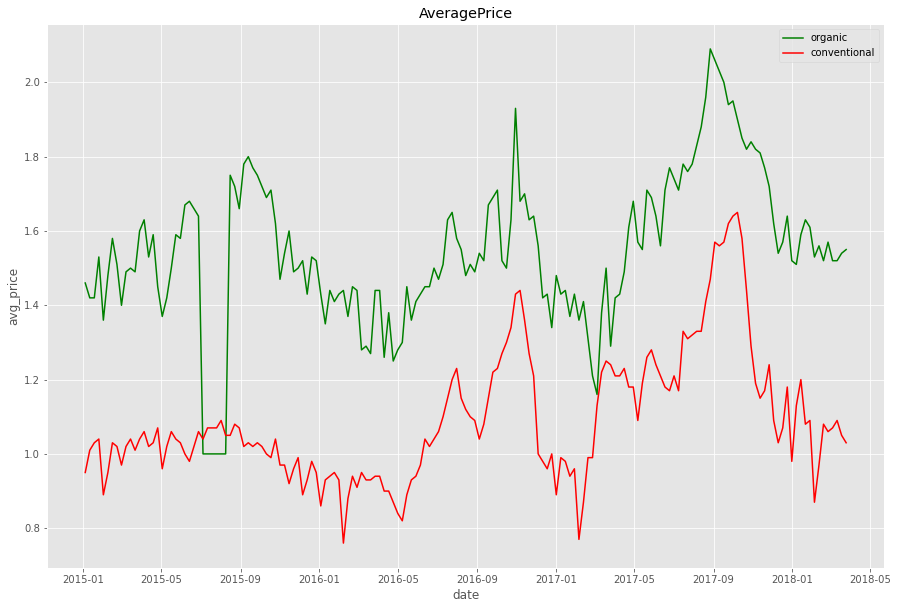

In [9]:
total_org = df[(df.type=='organic')&(df.region=='TotalUS')]
total_conv = df[(df.type=='conventional')&(df.region=='TotalUS')]
plt.figure(figsize = (15,10))
plt.title('AveragePrice')
plt.xlabel('date')
plt.ylabel('avg_price')
plt.plot(total_org.index, total_org.AveragePrice, color = 'green', label = 'organic')
plt.plot(total_conv.index, total_conv.AveragePrice, color = 'red', label = 'conventional')
plt.legend()
plt.show()

In [10]:
total_org

AveragePrice  Total Volume       4046       4225     4770  \
Date                                                                    
2015-01-04          1.46     612910.15  233286.13  216611.20  4370.99   
2015-01-11          1.42     669528.88  270966.74  260971.60  3830.42   
2015-01-18          1.42     713120.00  254319.58  311811.01  4020.85   
2015-01-25          1.53     556368.86  207494.87  212312.02  4753.87   
2015-02-01          1.36     740896.97  302561.47  259286.44  5852.28   
...                  ...           ...        ...        ...      ...   
2018-02-25          1.57    1459852.55  122912.97  340374.83  1063.32   
2018-03-04          1.52    1634430.77  142345.03  390129.50  1225.97   
2018-03-11          1.52    1664234.88  129169.72  408763.50  1401.87   
2018-03-18          1.54    1675804.22  170801.85  444949.69  1045.38   
2018-03-25          1.55    1559967.20  121007.94  342853.10  1070.24   

            Total Bags  Small Bags  Large Bags  XLarge Bags     type   region  
Date                                                                           
2015-01-04   158641.83   115068.71    43573.12         0.00  organic  TotalUS  
2015-01-11   133760.12   106844.49    26915.63         0.00  organic  TotalUS  
2015-01-18   142968.56   101850.23    41118.33         0.00  organic  TotalUS  
2015-01-25   131808.10    95964.83    35843.27         0.00  organic  TotalUS  
2015-02-01   173196.78   129953.15    43243.63         0.00  organic  TotalUS  
...                ...         ...         ...          ...      ...      ...  
2018-02-25   994471.50   765056.82   229158.56       256.12  organic  TotalUS  
2018-03-04  1099871.68   831885.50   267818.31       167.87  organic  TotalUS  
2018-03-11  1124621.50   944572.50   180049.00         0.00  organic  TotalUS  
2018-03-18  1058651.50   837351.85   221129.46       170.19  organic  TotalUS  
2018-03-25  1093861.09   902774.79   190941.84       144.46  organic  TotalUS  

[169 rows x 11 columns]

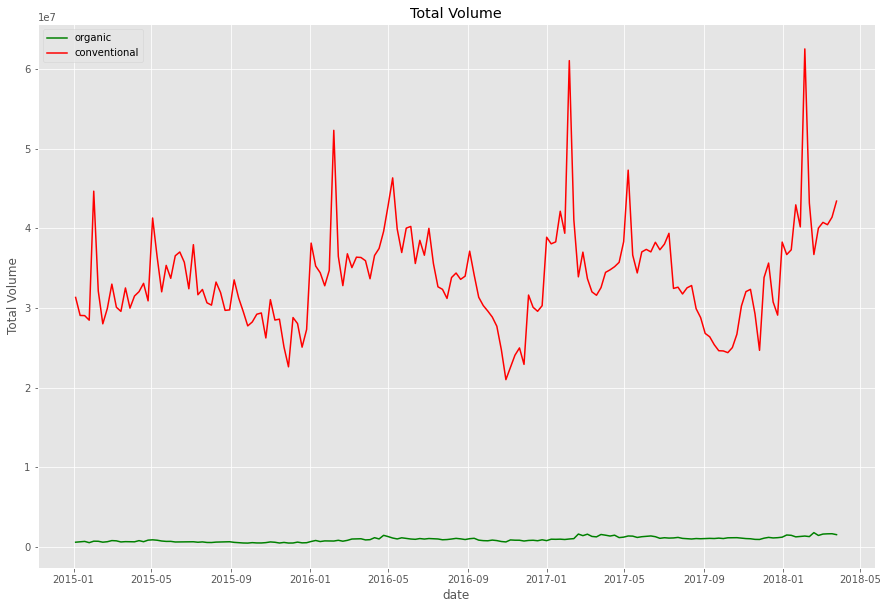

In [11]:
plt.figure(figsize = (15,10))
plt.title('Total Volume')
plt.xlabel('date')
plt.ylabel('Total Volume')
plt.plot(total_org.index, total_org['Total Volume'], color = 'green', label = 'organic')
plt.plot(total_conv.index, total_conv['Total Volume'], color = 'red', label = 'conventional')
plt.legend()
plt.show()

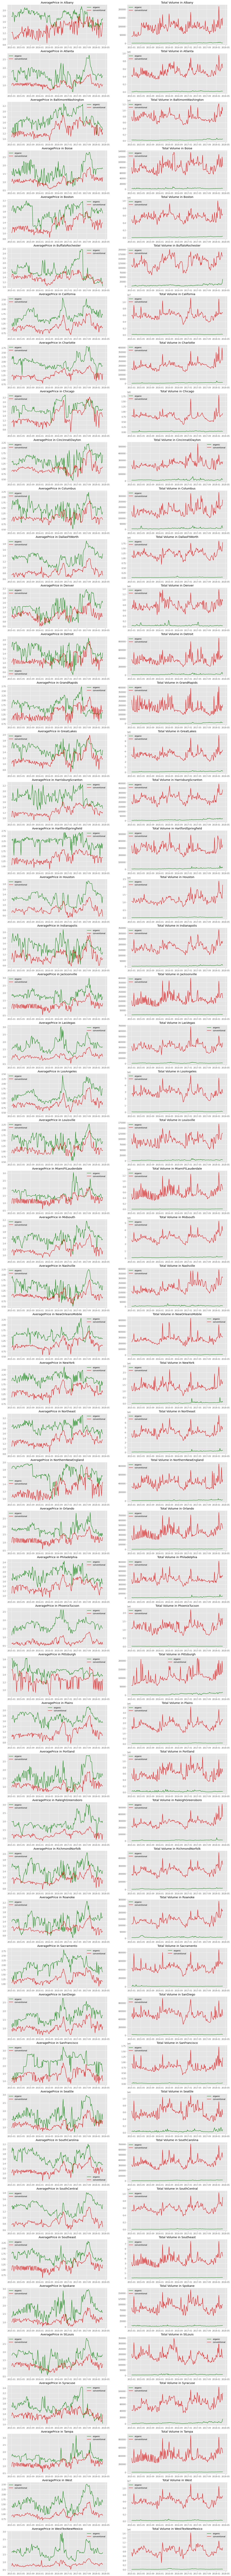

In [12]:
fig, axes = plt.subplots(53, 2)
fig.set_figheight(240)
fig.set_figwidth(20)
ind = 0
for elem in cities1:
    if elem!='TotalUS':
        total_org = df[(df.type=='organic')&(df.region==elem)]
        total_conv = df[(df.type=='conventional')&(df.region==elem)]
        axes[ind,0].plot(total_org.index, total_org.AveragePrice, color = 'green', label = 'organic')
        axes[ind,0].plot(total_conv.index, total_conv.AveragePrice, color = 'red', label = 'conventional')
        axes[ind,1].plot(total_org.index, total_org['Total Volume'], color = 'green', label = 'organic')
        axes[ind,1].plot(total_conv.index, total_conv['Total Volume'], color = 'red', label = 'conventional')
        axes[ind,0].set_title('AveragePrice in {}'.format(elem))
        axes[ind,1].set_title('Total Volume in {}'.format(elem))
        axes[ind,0].legend()
        axes[ind,1].legend()
        ind = ind +1

В ходе визуального анализа были выявлены следующие инсайды:
1. Объем продаж органических авокадо практически не претерпевал изменений в большинстве городов (за исключением Seattle, Syracuse, NewYork, Denver, Portland). Также он оставался на достаточно низком уровне и по стране в целом.
2. Объем продаж обычных авокадо в большинстве городов и штатов резко возрастает в конце зимы (пики в 2016-02, 2017-02, 2018-02), напр. в Калифорнии, Сакраменто, Сан-Франциско и др.
3. Цены на органические авокадо стабильно превышают цены на обычные, однако на общегосударственном уровне наблюдается резкое падение цен на органические авокадо в период с 2015-07 - 2015-08, причем цены падают ниже среднего уровня цен на обычные авокадо. Также, на уровне штатов наблюдается падение цен на авокадо в период с 2017-01 - 2017 -05 (например, Ричмонд - Норфолк, Роанок, Портланд). Вероятно, это свидетельствует о каком-то скандале, возможно связанном с несоответствием органических авокадо заявленному качеству

# Проверка статистических гипотез

# Параметрический критерий

Проверим, отличаются ли средние цены на авокадо за весь исследуемый период в штатах, находящихся в противоположных частях США.
Рассмотрим Нью-йорк и Калифорнию.

In [13]:
dataset1_conv = df[(df.region == 'California')&(df.type == 'conventional')]
dataset2_conv = df[(df.region == 'NewYork')&(df.type == 'conventional')]
dataset1_org = df[(df.region == 'California')&(df.type == 'organic')]
dataset2_org = df[(df.region == 'NewYork')&(df.type == 'organic')]

Применим критерий Стьюдента для несвязанных выборок. Гипотезы:

H0: цены на авокадо в Калифорнии и Нью-Йорке равны

H1: цены на авокадо в Калифорнии и Нью-Йорке различны

Проверяем для обычных авокадо:

In [14]:
t_stat = stats.ttest_ind(dataset1_conv.AveragePrice, dataset2_conv.AveragePrice)
t_stat

Ttest_indResult(statistic=-11.610533472843997, pvalue=1.9708260321209288e-26)

pvalue < 0.05, отвергаем гипотезу H0, цены на обычные авокадо различны

In [15]:
t_stat = stats.ttest_ind(dataset1_org.AveragePrice, dataset2_org.AveragePrice)
t_stat

Ttest_indResult(statistic=-13.37227721476897, pvalue=5.406156054372171e-33)

pvalue < 0.05, отвергаем гипотезу H0, цены на органические авокадо различны

А объемы продаж авокадо в Калифорнии и Нью-Йорке?

Опять применим критерий Стьюдента для несвязанных выборок. Гипотезы:

H0: объемы продаж авокадо в Калифорнии и Нью-Йорке равны

H1: объемы продаж авокадо в Калифорнии и Нью-Йорке различны

Проверяем для обычных авокадо:

In [16]:
t_stat = stats.ttest_ind(dataset1_conv['Total Volume'], dataset2_conv['Total Volume'])
t_stat

Ttest_indResult(statistic=48.94933576036695, pvalue=5.7810262263862015e-155)

pvalue < 0.05, отвергаем гипотезу H0, объемы продаж обычных авокадо в Калифорнии и Нью-Йорке различны

In [17]:
t_stat = stats.ttest_ind(dataset1_org['Total Volume'], dataset2_org['Total Volume'])
t_stat

Ttest_indResult(statistic=17.772418542385964, pvalue=2.7645185629309223e-50)

pvalue < 0.05, отвергаем гипотезу H0, объемы продаж органических авокадо в Калифорнии и Нью-Йорке различны

# Непараметрический критерий

Проверим гипотезу о том, что объем продаж органических авокадо в Лос-Анджелесе и Джэксонвилле совпадает

Используем критерий Манна-Уитни

$ H_0: F_{X_{1}} (x) =  F_{X_{2}} (x) $
    
$ H1: F_{X_{1}} (x) =  F_{X_{2}} (x + ∆),∆ <> 0 $

In [18]:
dataset1_org = df[(df.region == 'LosAngeles')&(df.type == 'organic')]
dataset2_org = df[(df.region == 'Jacksonville')&(df.type == 'organic')]

In [19]:
stats.mannwhitneyu(dataset1_org['Total Volume'], dataset2_org['Total Volume'], alternative = 'greater')

MannwhitneyuResult(statistic=28561.0, pvalue=3.290589927620308e-57)

p < 0.05, отвергаем нулевую гипотезу, объем продаж в Лос-Анджелесе больше

# Построить предсказание временного ряда

Построим прогноз объема продаж обычных авокадо на три месяца вперед:

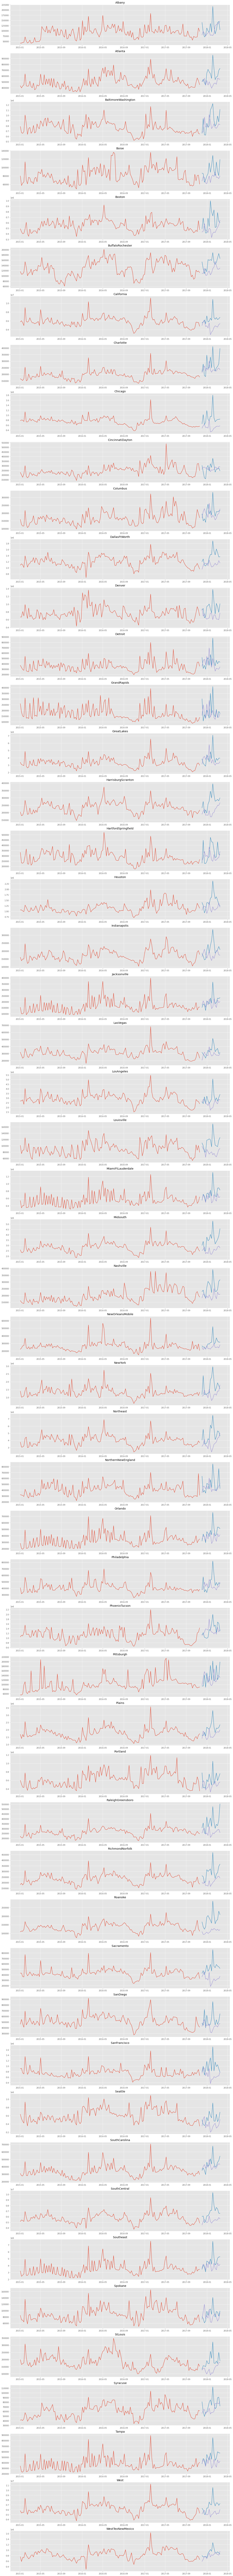

In [20]:
from sklearn.metrics import  mean_absolute_error as mae
results = []
fig, axes = plt.subplots(53, 1)
fig.set_figheight(240)
fig.set_figwidth(20)
ind = 0
for elem in cities1:
    if elem!='TotalUS':
        dataset = df[(df.type=='conventional')&(df.region==elem)]
        train = dataset['Total Volume'][:151]
        test = dataset['Total Volume'][152:168]
        fit1 = ExponentialSmoothing(np.asarray(train), 
                                    seasonal_periods=48,
                                    seasonal='add').fit()
        forecast = pd.Series(fit1.forecast(len(test)))
        forecast.index = test.index
        axes[ind].plot(train.index, train)
        axes[ind].plot(test.index, test)
        axes[ind].plot(forecast.index, forecast)
        axes[ind].set_title(elem)
        results.append(mae(test, forecast))
        ind = ind +1

Найдем ошибки прогнозов для всех штатов:

In [21]:
ind  = 0
for elem in cities1:
    if elem != 'TotalUS':
        print(elem, ': ', results[ind])
        ind = ind + 1

Albany :  30451.77120248436
Atlanta :  146331.19885390165
BaltimoreWashington :  176792.46339734562
Boise :  20236.83387318593
Boston :  185069.60000989126
BuffaloRochester :  34725.17792484836
California :  1835576.8267961054
Charlotte :  56074.14943616284
Chicago :  389356.55521287187
CincinnatiDayton :  51553.387469021814
Columbus :  45169.02125957707
DallasFtWorth :  270216.6031327337
Denver :  237399.07773453876
Detroit :  139943.3343701153
GrandRapids :  67602.58041739688
GreatLakes :  931488.8627302177
HarrisburgScranton :  71778.75768064283
HartfordSpringfield :  83641.10122392219
Houston :  401331.49413180724
Indianapolis :  53068.295267392474
Jacksonville :  35294.93852258548
LasVegas :  71498.16406818469
LosAngeles :  617713.0622717144
Louisville :  32875.16571087692
MiamiFtLauderdale :  152581.18475815153
Midsouth :  1088514.3186433995
Nashville :  67392.51376585197
NewOrleansMobile :  62107.456523364206
NewYork :  591706.0601222069
Northeast :  1400805.2837465727
NorthernN

# Выводы

Было проведено исследование датасета 'Avocado Prices'. Были изучены признаки в датасете, проведена необходимая предобработка данных. После этого я провел визуальный анализ данных. Построены графики средней цены и объема продах обычных и органических авокадо для разных регионов США. Показано, что объем продаж обычных авокадо значительно превосходит объем продаж органических авокадо. Также были выявлены сезонные пики продаж обычных авокадо, а также обнаружены моменты резкого ппдения цены на органические авокадо.

Также были проверены статистические гипотезы о совпадении цен и объемов продаж авокадо обеих типов в Калифорнии и Нью-Йорке (и обе опровергнуты), также было проерена гипотеза о равенстве объемов продаж органических авокадо в Лос-Анджелесе и Джэксонвилле, верной была признана альтернативная гипотеза - объем продаж в Лос-Анджелесе больше.

Также было проведено прогнозирование объема продаж обычных авокадо на три месяца вперед во всех представленных в датасете штатах (на 3 месяца вперед, методом тройного экспоненциального сглаживания).